In [95]:
import bilby
import h5py
from h5glance import H5Glance
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import math
from sklearn.neighbors import KernelDensity
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from astropy import units as u
from astropy.cosmology import WMAP5

%matplotlib inline

In [96]:
f=h5py.File('/home/sagi/Downloads/models_reduced.hdf5' , 'r')
f.keys()


<KeysViewHDF5 ['CE', 'CHE', 'GC', 'NSC', 'SMT']>

In [97]:
##prints out the data file with its structure
CE_chi02_alpha10 = pd.read_hdf('/home/sagi/Downloads/models_reduced.hdf5', key='/CE/chi02/alpha02/')
print(CE_chi02_alpha10[:4])

            mchirp         q    chieff         z         m1         m2  \
4574608  15.079619  0.866933  0.204811  0.431284  18.613366  16.136532   
4817603   6.962208  0.778284  0.351693  3.946317   9.079551   7.066470   
3547181  16.844822  0.972953  0.534173  1.586921  19.617090  19.086512   
555268   15.341755  0.962225  0.557582  0.174426  17.287628  17.966309   

             s1x       s1y       s1z       s2x       s2y       s2z    weight  \
4574608  0.00000  0.000000  0.202513  0.000000 -0.000000  0.207462  0.009824   
4817603  0.00208  0.002318  0.203924 -0.004333 -0.007047  0.541557  0.047776   
3547181  0.00000  0.000000  0.207408  0.000000 -0.000000  0.870022  0.054913   
555268  -0.00000 -0.000000  0.204812 -0.000000 -0.000000  0.897025  0.000171   

         pdet_midhighlatelow_network  snropt_midhighlatelow_network  \
4574608                        0.021                      13.407297   
4817603                        0.000                       1.382382   
3547181        

In [98]:

##stores all the chirpmass data in an array
data=f['/CE/chi02/alpha02/block0_values']
# Create the nested array
priors = np.array([
    np.array(data[:,0].reshape(-1,1)), # chirpmass
    np.array(data[:,1].reshape(-1,1)), # q
])

names=["chirp mass prior","q prior"]
chirpmass, q= priors



In [99]:

kde=[]
samples = [[] for _ in range(len(priors))]
density= [[] for _ in range(len(priors))]
for i in range(len(priors)):
    #priors[i]=priors[i].reshape(-1,1)
    kde.append(KernelDensity(kernel='gaussian', bandwidth=0.2).fit(priors[i][:1000]))
    samples[i]=np.abs(kde[i].sample(1000))
    density[i]=np.exp(kde[i].score_samples(samples[i][:1000]))
    samples[i]=samples[i].flatten()
    


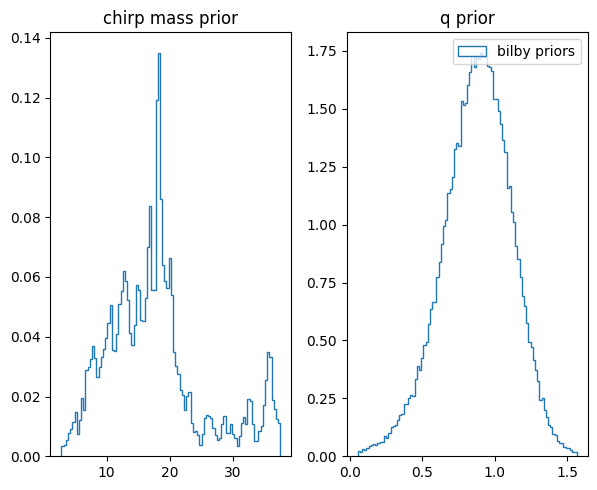

In [100]:

custom_priors = []
fig = plt.figure(figsize=(12, 5))

for i in range(len(names)):
    custom_priors.append (

        bilby.prior.Interped(
            name=names[i],
            xx=samples[i], #plotting chirp mass on the x axis 
            yy=density[i], 
           # minimum=0,
          #  maximum=100,
            #latex_label="chirpmass prior",
        ),
    )

for ii, prior in enumerate(custom_priors):
    fig.add_subplot(1, 4, 1 + ii)
    plt.hist(prior.sample(100000), bins=100, histtype="step", density=True,label="bilby priors")
    plt.title(names[ii])
    #kde=sns.kdeplot(data=samples[i], bw_method=0.2, cut=0, label=names)
    #kdem2=sns.kdeplot(data=m2, bw_method=0.2, cut=0, label="m2 KDE")
    

plt.legend()
plt.tight_layout()
plt.show()
plt.close()

In [101]:
data=[]
for i in range(len(names)):

    data.append(zip(samples[i], density[i]))
    
data = [list(zip(samples[i], density[i])) for i in range(len(names))]    

for i, array in enumerate(data):
    with open("{}(CE=0.2).txt".format(names[i]), "w") as file:
        for line in array:
            file.write(",".join(map(str,line)) + "\n")